<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#libs" data-toc-modified-id="libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>libs</a></span></li><li><span><a href="#tabelas" data-toc-modified-id="tabelas-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>tabelas</a></span><ul class="toc-item"><li><span><a href="#caso-binário" data-toc-modified-id="caso-binário-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>caso binário</a></span><ul class="toc-item"><li><span><a href="#seleção" data-toc-modified-id="seleção-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>seleção</a></span></li><li><span><a href="#objective-=-'binary'" data-toc-modified-id="objective-=-'binary'-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span><code>objective = 'binary'</code></a></span><ul class="toc-item"><li><span><a href="#reconstruindo-objetiva" data-toc-modified-id="reconstruindo-objetiva-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>reconstruindo objetiva</a></span></li><li><span><a href="#discussão-sobre-o-TERM" data-toc-modified-id="discussão-sobre-o-TERM-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>discussão sobre o TERM</a></span></li></ul></li></ul></li></ul></li></ul></div>

guiado pelos monstros sagrados que escreveram
+ ["Focal loss implementation for LightGBM" por Max Halford](https://maxhalford.github.io/blog/lightgbm-focal-loss/)
+ ["Tilted Empirical Risk Minimization" por Carnegie Mellon University](https://blog.ml.cmu.edu/2021/04/02/term/)

# libs

In [4]:
import datetime
import warnings
import pickle
import gc
import os
import math
import pprint
import hashlib
import functools

import numpy  as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display import display

warnings.filterwarnings('ignore')

<br/>

In [70]:
from scipy import special
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score

In [5]:
from boruta import BorutaPy
import optuna
import lightgbm as lgb

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import normalize, StandardScaler, LabelBinarizer
from sklearn.metrics         import classification_report, roc_curve, auc,accuracy_score, confusion_matrix, f1_score, fbeta_score, balanced_accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve
from boruta                  import BorutaPy
import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

import lightgbm as lgb         

# tabelas

```
"FS": suffered fouls,
"PE": missed passes,
"A": assistances,
"FT": shots on the post,
"FD": defended shots,
"FF": shots off target,
"G": goals,
"I": offsides,
"PP": missed penalties,
"RB": successful tackes,
"FC": fouls commited,
"GC": own goals,
"CA": yellow cards,
"CV": red cards,
"SG": clean sheets (only defenders),
"DD": difficult defenses (only goalies),
"DP": defended penalties (only goalies),
"GS": suffered goals (only goalies)
```

In [6]:
df = pd.read_csv('~/Documents/data/cartola-fc-brasil-scouts/jogadores.csv')

df = df.sort_values(by=["ano", "rodada"]).copy()
df['id']  = df['Nome'].apply( lambda x: hashlib.sha1(str.encode(x)).hexdigest() )
df['pos'] = df['Nome'].apply( lambda x: x.split('(')[-1].split(')')[0].strip() )

display( df )

scouts  = ['DS','G','A','SG','FS','FF','FD','FT','DD','DP','GC','CV','CA','PP','GS','FC','I','PI','RB','PE']
mercado = ['Preço', 'Média','Variação']
keys    = ["id", "ano"]

gscouts = df.groupby(keys)[scouts].agg(['sum', 'max'])
gscouts.columns = gscouts.columns.map('_'.join)
gscouts = gscouts.reset_index()

gmercado = df.groupby(keys)[mercado].agg(['sum','max'])
gmercado.columns = gmercado.columns.map('_'.join)
gmercado = gmercado.reset_index()

gpos = df.groupby(keys)[['pos']].agg(['first'])
gpos.columns = gpos.columns.map('_'.join)
gpos = gpos.reset_index()

display(gpos['pos_first'].value_counts())

,Nome,Clube,Preço,J,Média,Últ. Pont.,Variação,DS,G,A,...,GS,FC,I,PI,rodada,ano,RB,PE,id,pos
7882,Ricardo Bueno (ATA),Ceará,18.52,1.0,22.70,22.7,14.52,NaN,2.0,1.0,...,NaN,2.0,1.0,NaN,1,2019,1.0,1.0,1f4d452190fb0558c5f5696b944b9afe4b02ca08,ATA
7883,Bruno Henrique (ATA),Flamengo,21.51,1.0,21.00,21.0,11.51,NaN,2.0,NaN,...,NaN,1.0,NaN,NaN,1,2019,NaN,NaN,9f9a076464350d81d76c9b8940d64b9890e4b053,ATA
7884,Nikão (MEI),Athlético-PR,19.29,1.0,18.80,18.8,10.29,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,1,2019,5.0,NaN,9752a812f300239c0f4fcae95d41e2843653a308,MEI
7885,Tiepo (GOL),Chapecoense,13.18,1.0,17.00,17.0,11.18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,2019,NaN,NaN,ec9799d86e28ec368cccfb660bf39ff3bc3eed7c,GOL
7886,Vanderlei (GOL),Santos,22.69,1.0,15.70,15.7,5.69,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,1,2019,NaN,1.0,a5dde5accc0044a9808b0257f6faa5ba89342b7f,GOL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7877,Jadson (MEI),Athlético-PR,3.53,9.0,0.11,0.8,-0.40,NaN,NaN,NaN,...,NaN,3.0,NaN,40.0,38,2020,NaN,NaN,fe95e28e44efa7db07376c045a2fa89332ea5308,MEI
7878,Patrick de Lucca (MEI),Bahia,0.77,3.0,-0.23,-1.5,-0.29,1.0,NaN,NaN,...,NaN,NaN,NaN,25.0,38,2020,NaN,NaN,0157594398527348fc28f663c44291f22f8172ae,MEI
7879,Guilherme Biro (ATA),Coritiba,0.77,8.0,-0.32,-3.6,-0.21,15.0,NaN,NaN,...,NaN,14.0,NaN,41.0,38,2020,NaN,NaN,3e299fb9c705d57573fa4ab8a1a9f607edc60dc2,ATA
7880,Gabriel Pereira (MEI),Corinthians,0.79,5.0,-0.40,0.0,0.00,1.0,NaN,NaN,...,NaN,6.0,NaN,15.0,38,2020,NaN,NaN,90a8b33c4ac288f85fa4a7e678592dd30600d8a4,MEI


MEI    408
ATA    285
ZAG    203
LAT    200
GOL     96
TEC     91
Name: pos_first, dtype: int64

In [7]:
cols_ = ["Preço_max", "Média_max", "Variação_max",
         "Preço_sum", "Média_sum", "Variação_sum",
         
         "FS_max", "PE_max", "A_max", "FT_max", "FD_max", 
         "FF_max", "G_max", "I_max", "PP_max", "RB_max", 
         "FC_max", "GC_max", "CA_max", "CV_max",

         "FS_sum", "PE_sum", "A_sum", "FT_sum", "FD_sum", 
         "FF_sum", "G_sum", "I_sum", "PP_sum", "RB_sum", 
         "FC_sum", "GC_sum", "CA_sum", "CV_sum",

         "pos_first"]

X = pd.concat([gscouts.drop(columns=keys), gmercado.drop(columns=keys), gpos.drop(columns=keys)], axis=1).copy().fillna(-1.0)[cols_]
X.columns = X.columns.str.upper()

## caso binário

In [13]:
scaler = MinMaxScaler()

yy = pd.Categorical(1 * X["POS_FIRST"] == "ATA").codes
# yy = pd.Categorical(X["POS_FIRST"]).codes
xx = scaler.fit_transform( X.drop(columns=["POS_FIRST"]) )

In [14]:
x_ = X.drop(columns=["POS_FIRST"]).copy()
x_[x_.columns] = scaler.fit_transform( x_ )

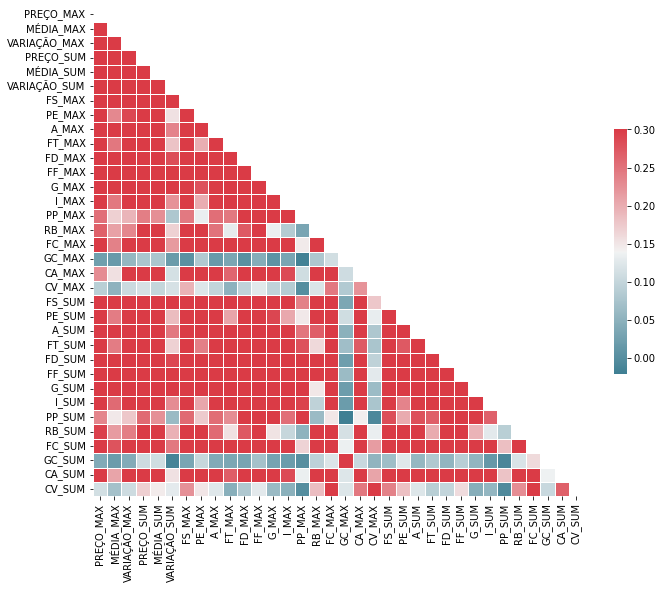

In [15]:
corr = x_.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
)

### seleção

In [19]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=500, oob_score=True)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter=23)

feat_selector.fit(x_.values, yy)

Iteration: 	1 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	2 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	3 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	4 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	5 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	6 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	7 / 23
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	8 / 23
Confirmed: 	12
Tentative: 	9
Rejected: 	13
Iteration: 	9 / 23
Confirmed: 	12
Tentative: 	9
Rejected: 	13
Iteration: 	10 / 23
Confirmed: 	12
Tentative: 	9
Rejected: 	13
Iteration: 	11 / 23
Confirmed: 	12
Tentative: 	9
Rejected: 	13
Iteration: 	12 / 23
Confirmed: 	12
Tentative: 	9
Rejected: 	13
Iteration: 	13 / 23
Confirmed: 	12
Tentative: 	8
Rejected: 	14
Iteration: 	14 / 23
Confirmed: 	12
Tentative: 	8
Rejected: 	14
Iteration: 	15 / 23
Confirmed: 	12
Tentative: 	8
Rejected: 	14
Iteration: 	16 / 23
Confirmed: 	13
Tentative: 	7
Rejected: 	14
Iteratio

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=63,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x7F96ABEB9740),
         max_iter=23, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F96ABEB9740, verbose=2)

In [20]:
accept = x_.columns[feat_selector.support_].to_list()
irresolution = x_.columns[feat_selector.support_weak_].to_list()

In [21]:
xx_ = feat_selector.transform(x_.values)

print(list(accept))
print('----------------------------')
print(list(irresolution))

['PREÇO_MAX', 'PREÇO_SUM', 'MÉDIA_SUM', 'FD_MAX', 'FF_MAX', 'G_MAX', 'I_MAX', 'FD_SUM', 'FF_SUM', 'G_SUM', 'I_SUM', 'FC_SUM', 'CA_SUM']
----------------------------
['MÉDIA_MAX', 'VARIAÇÃO_MAX', 'FS_MAX', 'RB_MAX', 'FC_MAX']


In [22]:
gc.collect()

272

In [23]:
print(x_[accept].shape)
print(yy.shape)

(1283, 13)
(1283,)


In [24]:
pd.Series(yy).value_counts(normalize=True).sort_index()

0    0.777864
1    0.222136
dtype: float64

In [25]:
# MEI    408
# ATA    285
# ZAG    203
# LAT    200
# GOL     96
# TEC     91
pd.Series(yy).value_counts()

0    998
1    285
dtype: int64

In [26]:
# depara = {
#     3 : "MEI",
#     0 : "ATA",
#     5 : "ZAG",
#     2 : "LAT",
#     1 : "GOL",
#     4 : "TEC"
# }
depara = {
    0 : "NOT",
    1 : "ATA",
}

### `objective = 'binary'`

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

for train_index, test_index in skf.split(x_[accept], yy):
    X_train, X_holdout = x_.iloc[train_index][accept], x_.iloc[test_index][accept]
    y_train, y_holdout = yy[train_index], yy[test_index]

In [52]:
hparams = {
    'bagging_freq': 8,
    'min_data_in_leaf': 47,
    'max_depth': 12,
    'learning_rate': 0.013471122435143618,
    'num_threads': 1,
    'min_sum_hessian_in_leaf': 8,
    'lambda_l1': 1.9486675127706043,
    'lambda_l2': 0.1118960383923103,
    'verbosity': -1,
    'num_threads': 5,
    'objective': 'binary'
}

In [53]:
X_fit, X_val, y_fit, y_val = train_test_split(X_train, y_train)

In [54]:
fit = lgb.Dataset(X_fit, y_fit)
val = lgb.Dataset(X_val, y_val, reference=fit)

<br/>

In [68]:
model = lgb.train(
    params=hparams,

    train_set=fit,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),

    num_boost_round=10000,
    early_stopping_rounds=200,
    verbose_eval=100
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[100]	fit's binary_logloss: 0.3318	val's binary_logloss: 0.379306
[200]	fit's binary_logloss: 0.274456	val's binary_logloss: 0.341306
[300]	fit's binary_logloss: 0.246079	val's binary_logloss: 0.328503
[400]	fit's binary_logloss: 0.232429	val's binary_logloss: 0.325511
[500]	fit's binary_logloss: 0.223221	val's binary_logloss: 0.327432
Early stopping, best iteration is:
[375]	fit's binary_logloss: 0.235155	val's binary_logloss: 0.325042


In [69]:
y_pred_train = np.where(model.predict(X_train) > 0.5, 1, 0)
y_pred_holdout = np.where(model.predict(X_holdout) > 0.5, 1, 0)
y_prob_holdout = model.predict(X_holdout)

metrica_t = balanced_accuracy_score(y_train, y_pred_train)
metrica_h = balanced_accuracy_score(y_holdout, y_pred_holdout)
metrica_d = metrica_t-metrica_h

print(classification_report(y_holdout, y_pred_holdout))

print(metrica_t)
print(metrica_h)
print(metrica_d)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       199
           1       0.80      0.56      0.66        57

    accuracy                           0.87       256
   macro avg       0.84      0.76      0.79       256
weighted avg       0.87      0.87      0.86       256

0.7963847353050963
0.7606012518734021
0.03578348343169424


#### reconstruindo objetiva

In [72]:
def logloss_objective(pred, train):
    y = train.get_label()
    p = special.expit(pred)
    grad = p-y
    hess = p * (1-p)
    return grad, hess

In [79]:
def logloss_metric(pred, train):
    y = train.get_label()
    p = special.expit(pred)
    
    ll = np.empty_like(p)
    pos = y==1
    ll[pos] = np.log(p[pos])
    ll[~pos] = np.log(1 - p[~pos])
    
    is_higher_better = False
    return 'logloss', -ll.mean(), is_higher_better

<br/>

as funções acima são reflexo do fato de no framework do **empirical risk minimization**, representado a grosso modo por

$$ \mathop{\mathrm{argmin}}\limits_{\theta} R(h_\theta) : R(h)= E\left[\mathcal{L}\left(h(x), y\right)\right] = \int \mathcal{L}\left(h(x), y\right) dP(x,y) \sim R_{\text{emp}}(h) = \frac{1}{n}\sum_{i}^{n} \mathcal{L}\left(h(x_i), y_i\right)$$

o problema de classificação binária em geral ter a função perda

$$ \mathcal{L} = -\sum_{i}^{n} y_i log(\hat{p_i}) + (1-\hat{p_i})log(1-\hat{p_i}) = -y_ilog(\text{odds}) + log\left(1 + e^{log(\text{odds})}\right) \qquad \left( \text{odds}=\frac{\hat{p_i}}{1-\hat{p_i}} \right)$$

e o algoritmo de otimização ser baseado em atualizações calculadas a partir das duas primeiras derivadas da função perda

$$ \nabla_{log(\text{odds})} \mathcal{L} = -y_i + \frac{e^{log(\text{odds})}}{1+e^{log(\text{odds})}} =-y_i + \hat{p_i}$$

e

$$ \nabla_{log(\text{odds})}^2 \mathcal{L} = \frac{e^{log(\text{odds})}}{(1+e^{log(\text{odds})})^2} =\hat{p_i}\frac{1}{(1+e^{log(\text{odds})})} = \hat{p_i}(1-\hat{p_i})$$

<br/>

In [80]:
hparams = {
    'bagging_freq': 8,
    'min_data_in_leaf': 47,
    'max_depth': 12,
    'learning_rate': 0.013471122435143618,
    'num_threads': 1,
    'min_sum_hessian_in_leaf': 8,
    'lambda_l1': 1.9486675127706043,
    'lambda_l2': 0.1118960383923103,
    'verbosity': -1,
    'num_threads': 5
}

In [81]:
model = lgb.train(
    params=hparams,

    train_set=fit,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),

    num_boost_round=10000,
    early_stopping_rounds=200,
    verbose_eval=100,
    fobj=logloss_objective,
    feval=logloss_metric
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[100]	fit's logloss: 0.376883	val's logloss: 0.410359
[200]	fit's logloss: 0.293264	val's logloss: 0.351781
[300]	fit's logloss: 0.255334	val's logloss: 0.333917
[400]	fit's logloss: 0.237752	val's logloss: 0.326833
[500]	fit's logloss: 0.227265	val's logloss: 0.327809
[600]	fit's logloss: 0.219783	val's logloss: 0.328096
Early stopping, best iteration is:
[417]	fit's logloss: 0.235623	val's logloss: 0.32639


In [82]:
y_pred_train = np.where(special.expit(model.predict(X_train)) > 0.5, 1, 0)
y_pred_holdout = np.where(special.expit(model.predict(X_holdout)) > 0.5, 1, 0)
y_prob_holdout = special.expit(model.predict(X_holdout))

metrica_t = balanced_accuracy_score(y_train, y_pred_train)
metrica_h = balanced_accuracy_score(y_holdout, y_pred_holdout)
metrica_d = metrica_t-metrica_h

print(classification_report(y_holdout, y_pred_holdout))

print(metrica_t)
print(metrica_h)
print(metrica_d)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       199
           1       0.82      0.54      0.65        57

    accuracy                           0.87       256
   macro avg       0.85      0.75      0.79       256
weighted avg       0.87      0.87      0.86       256

0.7948175350767407
0.7543418848629111
0.040475650213829595


<br/>

default
```
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[100]	fit's binary_logloss: 0.3318	val's binary_logloss: 0.379306
[200]	fit's binary_logloss: 0.274456	val's binary_logloss: 0.341306
[300]	fit's binary_logloss: 0.246079	val's binary_logloss: 0.328503
[400]	fit's binary_logloss: 0.232429	val's binary_logloss: 0.325511
[500]	fit's binary_logloss: 0.223221	val's binary_logloss: 0.327432
Early stopping, best iteration is:
[375]	fit's binary_logloss: 0.235155	val's binary_logloss: 0.325042

- - -

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       199
           1       0.80      0.56      0.66        57

    accuracy                           0.87       256
   macro avg       0.84      0.76      0.79       256
weighted avg       0.87      0.87      0.86       256

0.7963847353050963
0.7606012518734021
0.03578348343169424
```

custom
```
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[100]	fit's logloss: 0.376883	val's logloss: 0.410359
[200]	fit's logloss: 0.293264	val's logloss: 0.351781
[300]	fit's logloss: 0.255334	val's logloss: 0.333917
[400]	fit's logloss: 0.237752	val's logloss: 0.326833
[500]	fit's logloss: 0.227265	val's logloss: 0.327809
[600]	fit's logloss: 0.219783	val's logloss: 0.328096
Early stopping, best iteration is:
[417]	fit's logloss: 0.235623	val's logloss: 0.32639

- - -

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       199
           1       0.82      0.54      0.65        57

    accuracy                           0.87       256
   macro avg       0.85      0.75      0.79       256
weighted avg       0.87      0.87      0.86       256

0.7948175350767407
0.7543418848629111
0.040475650213829595
```

<br/>

#### discussão sobre o TERM

uma alternativa ao ERM é o TERM, representado a grosso modo por

$$R_{\text{emp}}(h) = \frac{1}{n}\sum_{i}^{n} \mathcal{L}\left(h(x_i), y_i\right) \longrightarrow \tilde{R}_{\text{emp}}(h,t) = \frac{1}{t} log \left( \frac{1}{n} \sum_{i}^{n} e^{ t \mathcal{L}\left(h(x_i), y_i\right)} \right)$$

.